In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms

import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

C:\Users\adria\anaconda3\envs\ml\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\adria\anaconda3\envs\ml\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(128, (0.5, 1)), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

train_data_IF = ImageFolder('./garbage_classification/', transform=train_transform)
test_data_IF = ImageFolder('./garbage_classification/', transform=test_transform)

num_classes = len(train_data_IF.classes)

In [3]:
n_test = int(0.1 * len(train_data_IF))
test_idx = random.choices(range(len(train_data_IF)), k=n_test)

test_data = torch.utils.data.Subset(test_data_IF, test_idx)
train_data = torch.utils.data.Subset(train_data_IF, [idx for idx in range(len(train_data_IF)) if idx not in test_idx])

In [4]:
batch_size=128
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1_16 = nn.Conv2d(3, 16, 1)
        self.conv3_16 = nn.Conv2d(3, 16, 3)
        self.conv5_16 = nn.Conv2d(3, 16, 5)
        
        self.conv1_32 = nn.Conv2d(16, 32, 1)
        self.conv3_32 = nn.Conv2d(16, 32, 3)
        self.conv5_32 = nn.Conv2d(16, 32, 5)
        
        self.conv3_16_16 = nn.Conv2d(16, 16, 3)
        self.conv5_16_16 = nn.Conv2d(16, 16, 5)
        
        self.max = nn.MaxPool2d(7)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(33488, 2048)
        self.linear2 = nn.Linear(2048, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        line1 = self.conv1_16(x)
        line1 = self.relu(line1)
        line1 = self.conv1_32(line1)
        line1 = self.relu(line1)
        line1 = self.max(line1)
        line1 = self.flatten(line1)
        
        line3 = self.conv3_16(x)
        line3 = self.relu(line3)
        line3 = self.conv3_32(line3)
        line3 = self.relu(line3)
        line3 = self.max(line3)
        line3 = self.flatten(line3)
        
        line5 = self.conv5_16(x)
        line5 = self.relu(line5)
        line5 = self.conv5_32(line5)
        line5 = self.relu(line5)
        line5 = self.max(line5)
        line5 = self.flatten(line5)
        
        line135 = self.conv1_16(x)
        line135 = self.relu(line135)
        line135 = self.conv3_16_16(line135)
        line135 = self.relu(line135)
        line135 = self.conv5_16_16(line135)
        line135 = self.relu(line135)
        line135 = self.max(line135)
        line135 = self.flatten(line135)
        
        out = torch.cat((line1, line3, line5, line135), dim=1)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        
        return out

In [6]:
device = torch.device('cuda')
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train(model, device, loss_fn, optimizer):
    epochs = 50
    best_acc = 0
    writer = SummaryWriter()

    for epoch in range(epochs):    
        running_loss = 0
        acc = 0
        batch_count = 0

        model.train()
        print(f'\nEpoch {epoch}:')
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            batch_count += 1

            optimizer.zero_grad()

            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()

            running_loss += loss.item()

            optimizer.step()
        running_loss /= batch_count
        writer.add_scalar('Loss/Train', running_loss, epoch)

        batch_count = 0

        with torch.no_grad():
            model.eval()
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                batch_count += 1

                output = model(x)
                acc += (torch.argmax(output, dim=1) == y).sum().item()/len(y)
            acc /= batch_count
            writer.add_scalar('Acc/Eval', acc, epoch)

        print(f'Train loss {running_loss:.6f} \tTest Accuracy {acc:.6f}')

        if acc > best_acc:
            print('New best model...', end='')
            best_acc = acc
            torch.save(model.state_dict(), './model/state_dict.pt')
            print('saved')

    writer.flush()
    writer.close()

In [8]:
train(model, device, loss_fn, optimizer)

Epoch 0:


100%|██████████| 52/52 [00:20<00:00,  2.56it/s]


Train loss 2.294409 	Test Accuracy 0.513081
New best model...saved
Epoch 1:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 1.191801 	Test Accuracy 0.576187
New best model...saved
Epoch 2:


100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Train loss 1.105940 	Test Accuracy 0.549509
Epoch 3:


100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Train loss 1.071368 	Test Accuracy 0.590449
New best model...saved
Epoch 4:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.982360 	Test Accuracy 0.554657
Epoch 5:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.939334 	Test Accuracy 0.622335
New best model...saved
Epoch 6:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.881644 	Test Accuracy 0.635296
New best model...saved
Epoch 7:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.852770 	Test Accuracy 0.670331
New best model...saved
Epoch 8:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.788076 	Test Accuracy 0.742521
New best model...saved
Epoch 9:


100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Train loss 0.747243 	Test Accuracy 0.747123
New best model...saved
Epoch 10:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.726170 	Test Accuracy 0.737978
Epoch 11:


100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Train loss 0.698740 	Test Accuracy 0.742460
Epoch 12:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.655861 	Test Accuracy 0.754815
New best model...saved
Epoch 13:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.620279 	Test Accuracy 0.765958
New best model...saved
Epoch 14:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.616102 	Test Accuracy 0.759387
Epoch 15:


100%|██████████| 52/52 [00:18<00:00,  2.81it/s]


Train loss 0.572212 	Test Accuracy 0.763324
Epoch 16:


100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Train loss 0.580469 	Test Accuracy 0.797148
New best model...saved
Epoch 17:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.559635 	Test Accuracy 0.788699
Epoch 18:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.533412 	Test Accuracy 0.787397
Epoch 19:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.503084 	Test Accuracy 0.801023
New best model...saved
Epoch 20:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.493450 	Test Accuracy 0.790001
Epoch 21:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.464550 	Test Accuracy 0.797178
Epoch 22:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.438616 	Test Accuracy 0.791909
Epoch 23:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.434072 	Test Accuracy 0.801054
New best model...saved
Epoch 24:


100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Train loss 0.404098 	Test Accuracy 0.797783
Epoch 25:


100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Train loss 0.392825 	Test Accuracy 0.803022
New best model...saved
Epoch 26:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.387954 	Test Accuracy 0.799721
Epoch 27:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.386433 	Test Accuracy 0.802356
Epoch 28:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.326193 	Test Accuracy 0.796481
Epoch 29:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.348771 	Test Accuracy 0.801750
Epoch 30:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.342804 	Test Accuracy 0.794604
Epoch 31:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.300353 	Test Accuracy 0.802326
Epoch 32:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.305778 	Test Accuracy 0.806262
New best model...saved
Epoch 33:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.288255 	Test Accuracy 0.805596
Epoch 34:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.296271 	Test Accuracy 0.797783
Epoch 35:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.283190 	Test Accuracy 0.809442
New best model...saved
Epoch 36:


100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Train loss 0.277221 	Test Accuracy 0.804960
Epoch 37:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.244253 	Test Accuracy 0.819253
New best model...saved
Epoch 38:


100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Train loss 0.248579 	Test Accuracy 0.817315
Epoch 39:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.249306 	Test Accuracy 0.817920
Epoch 40:


100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Train loss 0.238954 	Test Accuracy 0.831607
New best model...saved
Epoch 41:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.224733 	Test Accuracy 0.805596
Epoch 42:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.243131 	Test Accuracy 0.821191
Epoch 43:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.211183 	Test Accuracy 0.814711
Epoch 44:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.213168 	Test Accuracy 0.810804
Epoch 45:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.208608 	Test Accuracy 0.813348
Epoch 46:


100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Train loss 0.203423 	Test Accuracy 0.825097
Epoch 47:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.222211 	Test Accuracy 0.817315
Epoch 48:


100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Train loss 0.188236 	Test Accuracy 0.814014
Epoch 49:


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Train loss 0.188173 	Test Accuracy 0.832879
New best model...saved


In [9]:
model.load_state_dict(torch.load('./model/state_dict.pt'))

<All keys matched successfully>

In [10]:
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, './model.pt')

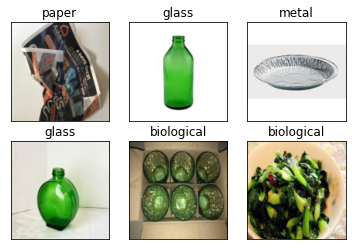

In [15]:
images = random.choices(test_data, k=6)
predictors = [torch.Tensor(i[0]) for i in images]

with torch.no_grad():
    model.eval()
    for i in range(6):
        prediction = test_data_IF.classes[torch.argmax(model(predictors[i].unsqueeze(0).to(device)))]
        plt.subplot(2, 3, i+1)
        plt.imshow(torch.transpose(torch.transpose(images[i][0], 0, 1), 1, 2))
        plt.title(prediction)
        plt.xticks([])
        plt.yticks([])